In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering.ranker import generate_ranker_features

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["ranker"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['ranker']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-04 23:46:49.194345: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-04 23:46:49.269140: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-04 23:46:49.692652: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_068
rm: cannot remove '/kaggle/output/exp_068': No such file or directory


In [2]:
oof = pd.read_csv(f'/kaggle/output/{CFG["2nd_stage"]["execution"]["best_exp_id"]}/oof.csv')
oof = oof.rename(columns={"oof": "oof_stage2"})
sub = pd.read_csv(f'/kaggle/output/{CFG["regressor"]["execution"]["best_exp_id"]}/submission.csv')
sub.drop(columns=["oof_stage2"], inplace=True)
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
display(oof.head())
display(sub.head())
display(labels.head())

,series_id,oof_1st,step,oof_stage2,minutes
0,038441c925bb,0.999923,11.5,0.999923,NaN
1,038441c925bb,0.999829,35.5,0.999829,NaN
2,038441c925bb,0.994979,59.5,0.994979,NaN
3,038441c925bb,0.993882,83.5,0.993882,NaN
4,038441c925bb,0.993127,107.5,0.993127,NaN


,step,sub_step_before_modify,key_step,series_id,score,event,oof_regressor,target,minutes,level
0,4319,4319.0,4331.5,038441c925bb,0.834676,onset,0.349690,0.0,NaN,5.0
1,4772,4679.0,4691.5,038441c925bb,0.834676,onset,93.151360,0.0,NaN,3.0
2,4988,4919.0,4931.5,038441c925bb,0.834676,onset,69.370323,73.0,1257.5,1.0
3,4996,5039.0,5051.5,038441c925bb,0.834676,onset,-42.952278,-47.0,1857.5,0.0
4,5004,5159.0,5171.5,038441c925bb,0.834676,onset,-154.876495,-167.0,2457.5,2.0


,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


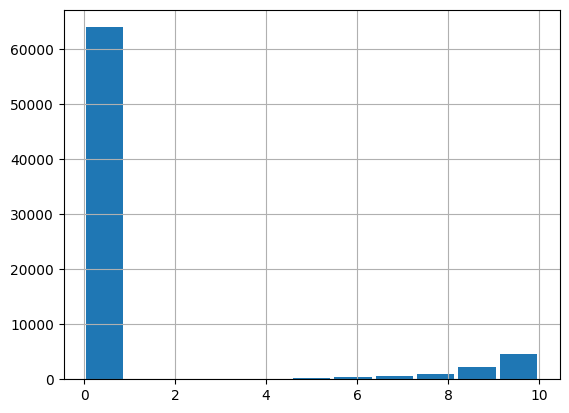

series_id                 5331163
step                      5331163
oof_stage2                5331163
minutes                    877617
target                      73351
sub_step                    73351
key_step                    73351
sub_step_before_modify      73351
event                       73351
level                       73351
score                       73294
oof_regressor               73351
dtype: int64
3.2182625660305457


,series_id,step,oof_stage2,minutes,target,sub_step,key_step,sub_step_before_modify,event,level,score,oof_regressor
0,038441c925bb,11.5,0.999923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,038441c925bb,35.5,0.999829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,038441c925bb,59.5,0.994979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,038441c925bb,83.5,0.993882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,038441c925bb,107.5,0.993127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# 正解ラベルを作成
thresholds = [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    targets = np.zeros(len(sub_df))
    for thresh in thresholds:
        matched = np.zeros(len(sub_df), dtype=bool)
        for step in label_df["step"].values:
            min_dist = thresh
            min_idx = -1            
            for idx, sub_step in enumerate(sub_df["step"].values):
                if matched[idx]:
                    continue
                dist = abs(step - sub_step)
                if dist < min_dist:
                    min_dist = dist
                    min_idx = idx
            if min_idx != -1:
                targets[min_idx] += 1
                matched[min_idx] = True
    sub_df["target"] = targets
    sub_df["sub_step"] = sub_df["step"].values
    dfs.append(sub_df)
sub = pd.concat(dfs).reset_index(drop=True)
plt.hist(sub["target"].values, bins=11, rwidth=0.9)
plt.grid()
plt.show()

train = oof[["series_id", "step", "oof_stage2", "minutes"]].merge(
    sub[["target", "series_id", 
         "sub_step", "key_step", "sub_step_before_modify",
         "event", "level", "score", "oof_regressor"]], 
    left_on=["series_id", "step"], 
    right_on=["series_id", "key_step"], 
    how="left",
    )
print((~train.isna()).sum())
print((train.target ** 2).mean() ** 0.5)
display(train.head())

In [4]:
# スコアの理論値(targetを完璧に当てれた場合)
ideal_sub = sub.copy()
ideal_sub["score"] = ideal_sub["target"]
ideal_sub["step"] = ideal_sub["sub_step"]

labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, ideal_sub)
print(f"score: {score:.4f}")
display(ap_table)

score: 0.8494


event   tolerance
onset   12           0.465456
        36           0.711152
        60           0.813316
        90           0.870999
        120          0.907116
        150          0.925288
        180          0.936437
        240          0.940107
        300          0.942709
        360          0.946596
wakeup  12           0.481989
        36           0.708667
        60           0.808609
        90           0.873474
        120          0.913561
        150          0.937360
        180          0.948042
        240          0.949846
        300          0.952572
        360          0.954516
dtype: float64

In [5]:
# 再現率
thresholds = [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    for thresh in thresholds:
        targets = np.zeros(len(label_df))
        for idx, step in enumerate(label_df["step"].values):           
            min_dist = thresh
            min_idx = -1            
            for sub_step in sub_df["step"].values:    
                dist = abs(step - sub_step)
                if dist < min_dist:
                    min_dist = dist
                    min_idx = idx
            if min_idx != -1:
                targets[idx] = True
        label_df["target"] = targets
        label_df["threshold"] = thresh
        dfs.append(label_df.copy())
recall_df = pd.concat(dfs).reset_index(drop=True)
print(recall_df["target"].mean())
display(recall_df.groupby(["event", "threshold"])["target"].mean())

0.8643505477308294


event   threshold
onset   12           0.468169
        36           0.717178
        60           0.821749
        90           0.882071
        120          0.920267
        150          0.941975
        180          0.953872
        240          0.958255
        300          0.961177
        360          0.966187
wakeup  12           0.486233
        36           0.716938
        60           0.819983
        90           0.889237
        120          0.932833
        150          0.958281
        180          0.969962
        240          0.972048
        300          0.974552
        360          0.976012
Name: target, dtype: float64

In [6]:
# 特徴生成
train, features = generate_ranker_features(train)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

100%|██████████| 277/277 [03:24<00:00,  1.35it/s]


,series_id,step,oof_stage2,minutes,target,sub_step,key_step,sub_step_before_modify,event,level,...,for_pred_rolling_min_50_shift_100_diff,oof_stage2_rolling_median_50_shift_100_diff,oof_stage2_diff_abs_rolling_median_50_shift_100_diff,oof_stage2_mean_rolling_median_50_shift_100_diff,for_pred_rolling_median_50_shift_100_diff,oof_stage2_rolling_square_mean_50_shift_100_diff,oof_stage2_diff_abs_rolling_square_mean_50_shift_100_diff,oof_stage2_mean_rolling_square_mean_50_shift_100_diff,for_pred_rolling_square_mean_50_shift_100_diff,fold
0,038441c925bb,4331.5,0.999193,NaN,0.0,4319.0,4331.5,4319.0,onset,5.0,...,0.0,0.960272,-0.002529,0.737917,0.0,0.998246,-0.000057,0.927509,0.0,2
1,038441c925bb,4691.5,0.998122,NaN,0.0,4772.0,4691.5,4679.0,onset,3.0,...,0.0,0.959926,-0.003268,0.719422,0.0,0.998064,-0.000062,0.921510,0.0,2
2,038441c925bb,4931.5,0.978979,1257.5,10.0,4988.0,4931.5,4919.0,onset,1.0,...,0.0,0.956779,-0.003403,0.711094,0.0,0.997368,-0.000110,0.908672,0.0,2
3,038441c925bb,5051.5,0.120360,1857.5,0.0,4996.0,5051.5,5039.0,onset,0.0,...,0.0,0.955621,-0.004250,0.706929,0.0,0.996829,-0.000130,0.899326,0.0,2
4,038441c925bb,5171.5,0.151996,2457.5,0.0,5004.0,5171.5,5159.0,onset,2.0,...,0.0,0.955607,-0.003614,0.704544,0.0,0.995787,-0.000106,0.888587,0.0,2


(73351, 1390)

In [7]:
# 学習
trn_oof, models = fit_xgb(
    X=train, 
    y=train["target"], 
    folds=train["fold"].astype(int), 
    features=features.all_features(),
    params=CFG["ranker"]["xgboost"], 
    es_rounds=100,
)
train["oof_ranker"] = trn_oof
train["score"] = train["oof_ranker"]
train["key_step"] = train["step"]
train["step"] = train["sub_step"].astype(int)
sub = train[["score", "key_step", "step", "event", "level", "series_id"]]

# 保存
for i, model in enumerate(models):
    model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))
with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:3.09303
[100]	eval-rmse:2.70595
[200]	eval-rmse:2.64024
[300]	eval-rmse:2.62616
[400]	eval-rmse:2.62290
[500]	eval-rmse:2.62257
[600]	eval-rmse:2.62205
[700]	eval-rmse:2.62226
[715]	eval-rmse:2.62190


 20%|██        | 1/5 [00:14<00:59, 14.78s/it]

== fold 1 ==
[0]	eval-rmse:3.10342
[100]	eval-rmse:2.73284
[200]	eval-rmse:2.66758
[300]	eval-rmse:2.65623
[400]	eval-rmse:2.65271
[500]	eval-rmse:2.65241
[563]	eval-rmse:2.65248


 40%|████      | 2/5 [00:25<00:38, 12.68s/it]

== fold 2 ==
[0]	eval-rmse:3.06520
[100]	eval-rmse:2.68935
[200]	eval-rmse:2.62275
[300]	eval-rmse:2.60913
[400]	eval-rmse:2.60556
[500]	eval-rmse:2.60419
[600]	eval-rmse:2.60470
[652]	eval-rmse:2.60487


 60%|██████    | 3/5 [00:39<00:25, 12.90s/it]

== fold 3 ==
[0]	eval-rmse:3.07849
[100]	eval-rmse:2.72618
[200]	eval-rmse:2.67801
[300]	eval-rmse:2.67213
[400]	eval-rmse:2.67177
[500]	eval-rmse:2.67205
[529]	eval-rmse:2.67225


 80%|████████  | 4/5 [00:49<00:12, 12.08s/it]

== fold 4 ==
[0]	eval-rmse:3.02002
[100]	eval-rmse:2.65104
[200]	eval-rmse:2.59598
[300]	eval-rmse:2.58823
[400]	eval-rmse:2.58802
[436]	eval-rmse:2.58893


100%|██████████| 5/5 [00:59<00:00, 11.89s/it]


In [8]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)

score: 0.6459


event   tolerance
onset   12           0.160240
        36           0.475347
        60           0.604290
        90           0.675062
        120          0.715942
        150          0.742266
        180          0.760728
        240          0.779378
        300          0.790523
        360          0.798127
wakeup  12           0.160999
        36           0.464757
        60           0.591272
        90           0.660853
        120          0.701892
        150          0.728389
        180          0.745256
        240          0.769195
        300          0.790060
        360          0.803820
dtype: float64